In [1]:
import sys, os, re
import numpy as np

import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.path import Path

import scipy.ndimage as nd
from skimage.segmentation import active_contour
from skimage.color import label2rgb
import skimage.morphology as morpho
from skimage.measure import regionprops, label, find_contours

from deeplate.MMdata import MMData 
import deeplate.platesegmenter as ps

from skimage.filters import gaussian, scharr_h,scharr_v
from skimage.filters.rank import enhance_contrast
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import disk
from skimage.morphology import watershed

/scicore/home/nimwegen/witzg/DeepPlateSegmenter/venv-deeplate/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound'

In [3]:
MMobj = MMData(folder = folder)
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
z_step = MMobj.get_zstep()

In [4]:
#this shows you the order of color acqusition
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [5]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [6]:
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

/scicore/home/nimwegen/witzg/DeepPlateSegmenter/venv-deeplate/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


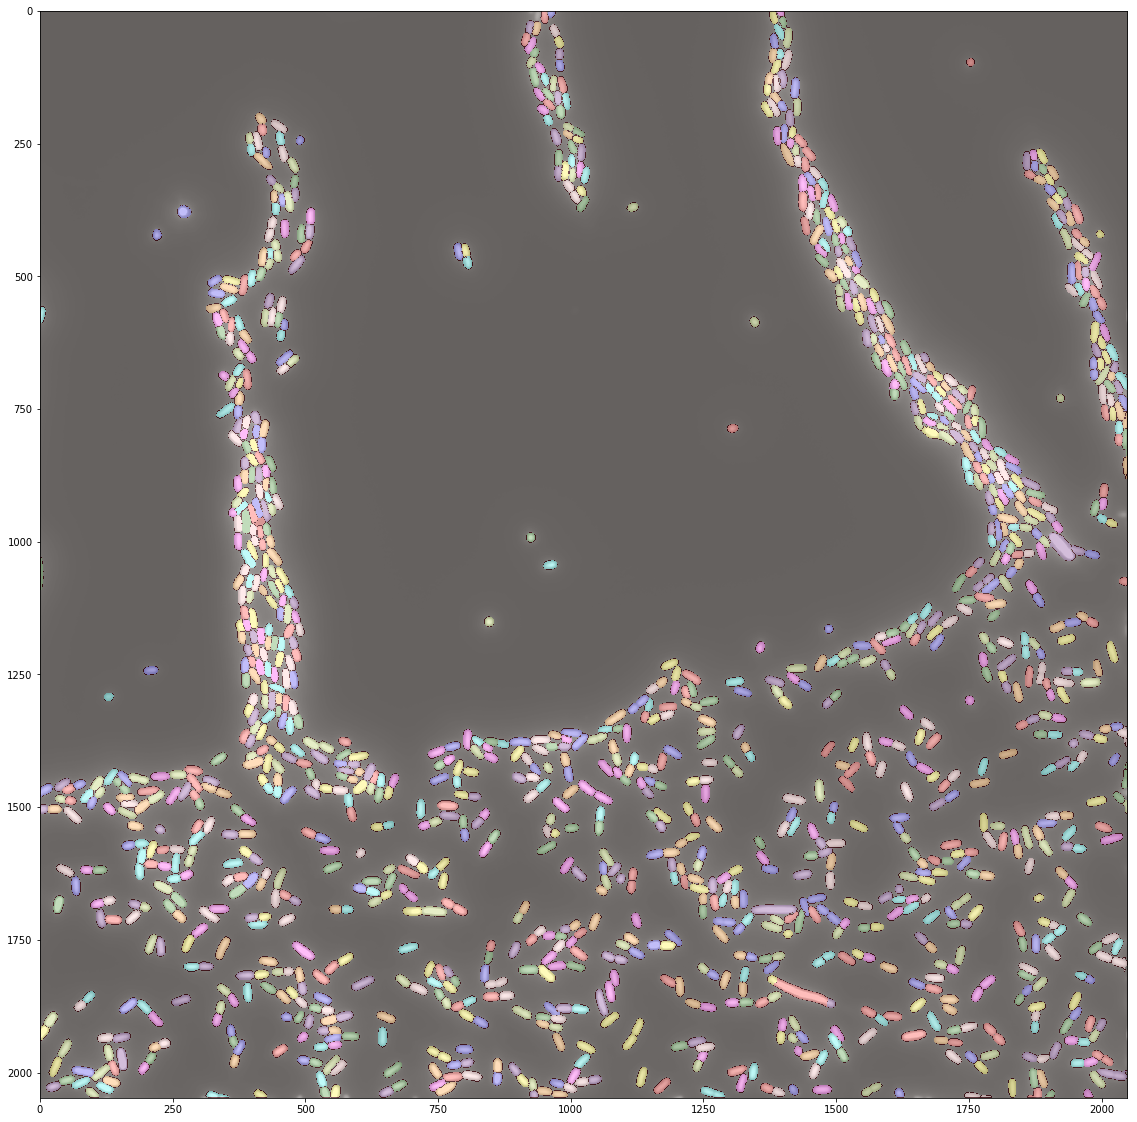

In [30]:
tot_cells = 0
for i in range(228):
    imfluo = MMobj.get_stack_fast(frame=0,channel=fluo_ch,position=i, compress = 1)[:,:,0]
    imfluo_gauss = gaussian(imfluo,1)
    imfluo_contrast = enhance_contrast(imfluo_gauss/np.max(imfluo_gauss), disk(5))
    sh = scharr_h(gaussian(imfluo_contrast,sigma=1))
    sv = scharr_v(gaussian(imfluo_contrast,sigma=1))
    sch = np.sqrt(sh**2+sv**2)
    
    sch_th = sch.copy()
    sch_th[sch_th<0.02]=0
    sch_th[sch_th>=0.02]=1
    sch_th[:,0]=1
    sch_th[:,-1]=1
    sch_th[0,:]=1
    sch_th[-1,:]=1
    sch_th_lab = label(1-sch_th)
    sch_th[:,0]=3
    sch_th[:,-1]=3
    sch_th[0,:]=3
    sch_th[-1,:]=3
    labels = label(sch_th+1)

    labelCount = np.bincount(labels.ravel())
    background = np.argmax(labelCount)
    sch_th_fill = np.zeros(sch_th.shape)
    sch_th_fill[labels != background] = 1
    sch_th_fill[:,0]=0
    sch_th_fill[:,-1]=0
    sch_th_fill[0,:]=0
    sch_th_fill[-1,:]=0

    im_water = watershed(-imfluo,sch_th_lab,mask = sch_th_fill,watershed_line=True)
    
    cell_info = regionprops(im_water)
    cell_info = [x for x in cell_info if (x.area>100)&(x.area<10000)]    
    cell_info = [x for x in cell_info if (x.solidity>0.75)]
    newMask = np.zeros(im_water.shape)
    for x in range(len(cell_info)):
        newMask[cell_info[x].coords[:,0],cell_info[x].coords[:,1]]=x
    #masktot = label(newMask)
    masktot = newMask.copy()
    
    #masktot = im_water.copy()
    masktot[masktot>0]=1
    distance = nd.distance_transform_edt(masktot)
    distance[distance != 1] = 0
    distance = morpho.binary_dilation(distance)
    distance[masktot==1] = 0
    
    fig,ax = plt.subplots(figsize=(20,20))
    plt.imshow(imfluo_gauss/np.max(imfluo_gauss),cmap = 'gray',vmin=0.0,vmax=0.5)
    plt.imshow(label2rgb(label(newMask),bg_label=0),alpha =0.2)
    plt.imshow(distance,alpha =0.2,cmap='Reds')
    plt.show()
    
    fig.savefig(path_to_save+'/segplot'+str(i)+'.png',dpi = 150)
    
    np.save(path_to_save+'/'+'mask_'+str(i)+'.npy', masktot)
    np.save(path_to_save+'/'+'weight_'+str(i)+'.npy', distance)
    
    tot_cells+= np.sum(masktot)